In [1]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
# from simpletransformers.t5 import T5Model, T5Args
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import json
import random
# Pull reddit data from reddit api
import requests
from bs4 import BeautifulSoup
import math
#tf for RNN
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
df = pd.read_csv('similar_subreddits_5000_df.csv')
#df = pd.read_csv('handpicked_subreddits_5000_df.csv')
#df = pd.read_csv('random_subreddits_5000_df.csv')
df.head()

,subreddit,text
0,gaming,'Four Friends' by SpaceCaptSteve
1,gaming,Your Welcome
2,gaming,Mum surprised me with this for my birthday.
3,gaming,ASUS Announces GeForce GTX 970 Turbo Graphics ...
4,gaming,Read and give the reviews and rating on app ga...


In [3]:
# Check if there is body text in reddit post
print(df['text'][0])

'Four Friends' by SpaceCaptSteve


In [4]:
# Check if total is correct per subreddit
df['subreddit'].value_counts()

gaming             5000
PS4                5000
pokemon            5000
xboxone            5000
leagueoflegends    5000
Name: subreddit, dtype: int64

In [5]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'gaming': 0, 'PS4': 1, 'pokemon': 2, 'xboxone': 3, 'leagueoflegends': 4}

In [6]:
#de-slang text
slang = pd.read_csv('slangit.csv')
slangit_dict = slang.set_index('Slang Term').to_dict()
slangit_dict = slangit_dict['Meaning']

def slang_lookup(text, dictionary):
    
    try:
        pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')(?!\w)')
        result = pattern.sub(lambda x: dictionary[x.group()], text)
    except:
        result = text

    return result

df['text'] = df['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df['text'].head()

0                     'Four Friends' by SpaceCaptSteve
1                                         Your Welcome
2          Mum surprised me with this for my birthday.
3    ASUS Announces GeForce GTX 970 Turbo Graphics ...
4    Read and give the reviews and rating on app ga...
Name: text, dtype: object

In [7]:
df['label'] = df.subreddit.replace(label_dict)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [9]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [10]:
df.groupby(['subreddit', 'label', 'data_type']).count()

text
subreddit       label data_type      
PS4             1     train      4000
                      val        1000
gaming          0     train      4000
                      val        1000
leagueoflegends 4     train      4000
                      val        1000
pokemon         2     train      4000
                      val        1000
xboxone         3     train      4000
                      val        1000

In [11]:
df.head()

,subreddit,text,label,data_type
0,gaming,'Four Friends' by SpaceCaptSteve,0,train
1,gaming,Your Welcome,0,train
2,gaming,Mum surprised me with this for my birthday.,0,train
3,gaming,ASUS Announces GeForce GTX 970 Turbo Graphics ...,0,val
4,gaming,Read and give the reviews and rating on app ga...,0,val


In [12]:
train_dataset = df[df.data_type == 'train']
val_dataset = df[df.data_type == 'val']

train_dataset = train_dataset.drop(['subreddit','data_type'], axis = 1)
val_dataset = val_dataset.drop(['subreddit','data_type'], axis = 1)
train_X, train_Y = train_dataset['text'], train_dataset['label']
test_X, test_Y = val_dataset['text'], val_dataset['label']
hot_train_Y = pd.get_dummies(train_dataset.label)
hot_test_Y = pd.get_dummies(val_dataset.label)
hot_test_Y


,0,1,2,3,4
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
9,1,0,0,0,0
16,1,0,0,0,0
...,...,...,...,...,...
24984,0,0,0,0,1
24988,0,0,0,0,1
24991,0,0,0,0,1
24995,0,0,0,0,1


In [13]:
test_X

3        ASUS Announces GeForce GTX 970 Turbo Graphics ...
4        Read and give the reviews and rating on app ga...
5            The Top 10 Most Influential Racing Games Ever
9        I have had probably over 1000 hours of minecra...
16                         Doodle of Master Chief [M.C.C.]
                               ...                        
24984    *Happy Father's Day to the best father in all ...
24988    Hi!  Just wanted a really fun character to pla...
24991                    still doesn't show LP change. gj.
24995    Hello, i download last day that champion.gg ca...
24999                                      Urf alternative
Name: text, Length: 5000, dtype: object

In [14]:
labels = tf.constant(train_Y)
features = tf.constant(train_X)

train_dataset_tf = tf.data.Dataset.from_tensor_slices((features,labels))
#train_dataset_tf = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
print(train_dataset_tf.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [15]:
#test vectorization
for example, label in train_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())


text:  b"'Four Friends' by SpaceCaptSteve"

label:  0


In [16]:
labels_val = tf.constant(test_Y)
features_val = tf.constant(test_X)

val_dataset_tf = tf.data.Dataset.from_tensor_slices((features_val,labels_val))
print(val_dataset_tf)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [17]:
#test vectorization
for example, label in val_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())

text:  b'ASUS Announces GeForce GTX 970 Turbo Graphics Card'

label:  0


In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [19]:
train_dataset_tf = train_dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_tf = val_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
#create text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset_tf.map(lambda text, labels: text))

In [21]:
#make RNN model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #bidirectional expects 3D input
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False)),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(5,activation = 'softmax'), 
    # tf.keras.layers.Dense(1, activation = 'softmax')
])

In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
        
        

In [23]:
#training not working because the input doesn't fit. There shouldn't be anything empty, null, or Nan so maybe an exploding gradient?
history = model.fit(train_X, hot_train_Y, epochs=1, batch_size = 64, validation_data=(test_X, hot_test_Y))

313/313 [==============================] - 239s 731ms/step - loss: 1.1175 - accuracy: 0.5443 - val_loss: 0.8790 - val_accuracy: 0.6602


In [24]:
preds = model.predict(test_X)
y_pred = np.argmax(preds, axis = 1)

In [25]:
import sklearn
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(test_Y, y_pred, average = 'micro')
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.6602
Recall: 0.6602
F1: 0.6602


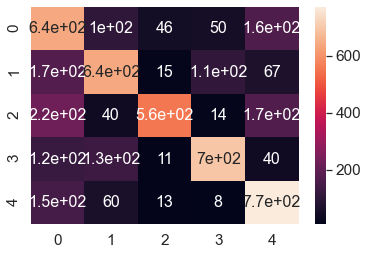

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt

array = sklearn.metrics.confusion_matrix(test_Y, y_pred)
#print(cm)

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

